### Import Necessary Dependencies

In [491]:
#Import libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist

import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from keras import optimizers
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

import gensim
from gensim.models import Word2Vec

np.random.seed(0)

%matplotlib inline
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/Filip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Filip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Read and Load the Dataset

In [158]:
# Upload datasets
df = pd.read_csv('tweet_product_company.csv', encoding = 'unicode_escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Exploratory Data Analysis

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [160]:
len(df.emotion_in_tweet_is_directed_at.unique())

10

In [161]:
df.columns = ['tweet_text', 'product', 'label']
df.head()

,tweet_text,product,label
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [162]:
for column in df.columns[1:]:
    print('Column: ', column)
    print('Unique values count:', len(df[column].unique()))
    print('Values: ', df[column].unique())
    print('----------------')

Column:  product
Unique values count: 10
Values:  ['iPhone' 'iPad or iPhone App' 'iPad' 'Google' nan 'Android' 'Apple'
 'Android App' 'Other Google product or service'
 'Other Apple product or service']
----------------
Column:  label
Unique values count: 4
Values:  ['Negative emotion' 'Positive emotion'
 'No emotion toward brand or product' "I can't tell"]
----------------


In [163]:
# Create summary of Nan and unique values counts and data types
X_info = pd.DataFrame(df.isna().sum(), columns=['NaN count'])

unique_val = []
types_val = []
zero_val = []

for column in df.columns:
    unique = df[column].nunique()
    types = str(df[column].dtype)
    zeros = len(df[df[column]==0])
    
    unique_val.append(unique)
    types_val.append(types)
    zero_val.append(zeros)

X_info['Zero values count'] = zero_val
X_info['Unique_val count'] = unique_val
X_info['Data type'] = types_val

X_info.sort_values(by=['NaN count', 'Zero values count'], ascending=False)

,NaN count,Zero values count,Unique_val count,Data type
product,5802,0,9,object
tweet_text,1,0,9065,object
label,0,0,4,object


### Data Visualization of Target Variables

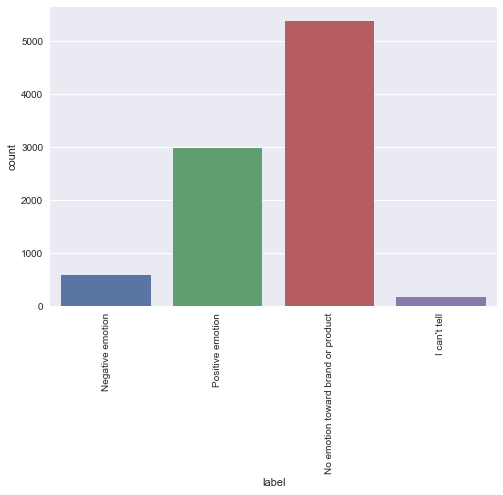

In [164]:
ax = sns.countplot(x='label', data=df)
ax.tick_params(axis='x', rotation=90)

In [165]:
df['label'].value_counts(normalize=True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: label, dtype: float64

In [166]:
df.groupby(by=['product']).count()

,tweet_text,label
product,,
Android,78,78
Android App,81,81
Apple,661,661
Google,430,430
Other Apple product or service,35,35
Other Google product or service,293,293
iPad,946,946
iPad or iPhone App,470,470
iPhone,297,297


### Cleaning and Preprocessing Data

In [167]:
df.dropna(subset=['tweet_text'], axis='rows', inplace=True)

#### Break apart the data and the labels, and then inspect the class names

In [421]:
data = df.drop(columns=['label','product'])
target = df.drop(columns=['tweet_text','product'])

In [422]:
#change type of column
target['label'] = pd.Categorical(target['label'])

In [423]:
target['label'] = target['label'].cat.codes

In [424]:
label_names = list(target['label'].unique())
label_names

[1, 3, 2, 0]

In [425]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42)

In [426]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [427]:
X_train[:1]

,tweet_text
8605,Perfect attention to detail RT @mention Google...


In [428]:
y_train

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

#### Check tweet lenghts distrubution and max value

max phrase len: 33


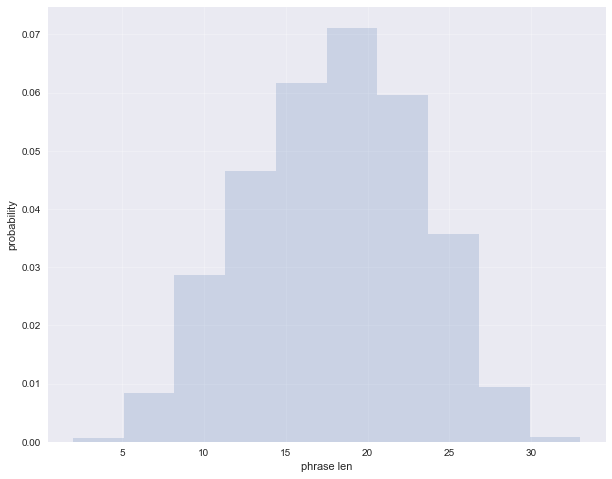

In [429]:
phrase_len = X_train['tweet_text'].apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))

#Plot results
plt.figure(figsize = (10, 8))
plt.hist(phrase_len, alpha = 0.2, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

In [461]:
# #### Getting a list of all of the english stopwords, and concatenating 
# them with a list of all the punctuation.
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']

In [462]:
def process_tweet(tweet):
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed

In [463]:
X_train_processed = X_train.applymap(process_tweet)

# X_train_processed['tweet_text'] = X_train_processed['tweet_text'].apply(lambda x: ' '.join(map(str, x)))
X_train_processed

,tweet_text
8605,"[perfect, attention, detail, rt, mention, goog..."
1303,"[iphone, stolen, got, back, sxsw]"
8759,"[fuck, love, austin, left, youtube, google, pa..."
5021,"[spotted, something, rare, minutes, ago, phone..."
3210,"[mention, fyi, rt, mention, 'll, austin, conve..."
...,...
5735,"[rt, mention, notatsxsw, sxsw, 's, link, free,..."
5192,"[rt, mention, quot, future, local, contextual,..."
5391,"[rt, mention, android, may, gaining, market, s..."
861,"[mention, love, mention, mention, sxsw, quot, ..."


In [464]:
X_test_processed = X_test.applymap(process_tweet)

# X_test_processed['tweet_text'] = X_test_processed['tweet_text'].apply(lambda x: ' '.join(map(str, x)))
X_test_processed

,tweet_text
7169,"[google, close, launching, new, social, networ..."
2089,"[iphone, charging, sxsw, link]"
2303,"[walk, lady, bird, lake, lovely, google, maps,..."
928,"[ûï, mention, rumor, apple, popup, store, dow..."
5895,"[rt, mention, google, launch, major, new, soci..."
...,...
4565,"[mention, needs, driving, buddy, 30, hours, al..."
548,"[go, sxsw, next, year, rt, mention, apple, ope..."
27,"[someone, started, austin, partnerhub, group, ..."
6220,"[mention, spilled, beans, next, platform, flip..."


### Word2vec

In [523]:
data_processed = data.applymap(process_tweet)
# data_processed['tweet_text'] = data_processed['tweet_text'].apply(lambda x: ' '.join(map(str, x)))

In [524]:
data_processed

,tweet_text
0,"[wesley83, 3g, iphone, 3, hrs, tweeting, rise_..."
1,"[jessedee, know, fludapp, awesome, ipad/iphone..."
2,"[swonderlin, wait, ipad, 2, also, sale, sxsw]"
3,"[sxsw, hope, year, 's, festival, n't, crashy, ..."
4,"[sxtxstate, great, stuff, fri, sxsw, marissa, ..."
...,...
9088,"[ipad, everywhere, sxsw, link]"
9089,"[wave, buzz, rt, mention, interrupt, regularly..."
9090,"[google, 's, zeiger, physician, never, reporte..."
9091,"[verizon, iphone, customers, complained, time,..."


In [525]:
target = to_categorical(target)

In [577]:
%%time
model_w2v = gensim.models.Word2Vec(
            data_processed['tweet_text'],
            size=10, # desired no. of features/independent variables
            window=5, # context window size
            min_count=1, # Ignores all words with total frequency lower than 2.                                  
            workers= 4, # no.of cores
) 

model_w2v.train(data_processed, total_examples=model.corpus_count, epochs=model_w2v.epochs)

CPU times: user 1.54 s, sys: 29 ms, total: 1.57 s
Wall time: 943 ms


(25, 50)

In [578]:
# model_w2v.wv.vocab

In [579]:
wv=model_w2v.wv

In [580]:
wv.most_similar(positive="apple")

[('open', 0.9979462027549744),
 ('heads', 0.9973016977310181),
 ('shop', 0.9967005252838135),
 ('sets', 0.9962363243103027),
 ('core', 0.9961278438568115),
 ('til', 0.9959115982055664),
 ('setting', 0.9948117136955261),
 ('congress', 0.9935564994812012),
 ('store', 0.9932241439819336),
 ('ipad2', 0.9924846291542053)]

In [581]:
wv.vocab['apple']

In [582]:
model_w2v['apple']

array([ 2.4460669 ,  1.2359698 ,  0.16042934, -1.5301412 , -3.1152124 ,
        6.190656  ,  4.209402  , -2.029335  ,  1.5898981 , -5.158054  ],
      dtype=float32)

In [583]:
w2v_dict = dict(zip(wv.index2word, wv.syn0))

#### Preparing Vectors for Tweets

Since our data contains tweets and not just words, we’ll have to figure out a way to use the word vectors from word2vec model to create vector representation for an entire tweet. There is a simple solution to this problem, we can simply take mean of all the word vectors present in the tweet. The length of the resultant vector will be the same, i.e. 200. We will repeat the same process for all the tweets in our data and obtain their vectors. Now we have 200 word2vec features for our data.

We will use the below function to create a vector for each tweet by taking the average of the vectors of the words present in the tweet.

In [584]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(w2v_dict))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])


In [585]:
vectorizer = W2vVectorizer(w2v_dict)

In [614]:
X_train_processed_mean = vectorizer.transform(X_train_processed['tweet_text'])

In [617]:
X_train_processed_mean

array([[ 0.07366225, -0.5588233 , -0.51509637, ...,  0.27175903,
         0.262583  , -1.1410797 ],
       [-0.00447785, -0.6876461 , -1.1996212 , ..., -0.03787825,
        -0.05701221, -2.3166475 ],
       [ 0.24799654, -0.47710997, -0.60808253, ...,  0.04175477,
         0.2726131 , -1.6937029 ],
       ...,
       [ 0.20331241, -0.4003264 , -0.57564193, ...,  0.03215329,
         0.22798003, -1.7028625 ],
       [ 0.41246516, -0.40693516, -0.84617233, ..., -0.10189325,
         0.3456574 , -2.6916993 ],
       [ 0.76031333,  0.15533613, -0.39618683, ..., -0.76201767,
         0.69359684, -2.4768147 ]], dtype=float32)

In [588]:
X_test_processed_mean = vectorizer.transform(X_test_processed['tweet_text'])

In [589]:
len(X_test_processed_mean[0])

10

In [590]:
X_test_processed_mean

array([[-5.86643994e-01, -3.01160955e+00, -2.41641951e+00, ...,
         1.67354369e+00,  1.07939065e+00, -2.23581457e+00],
       [ 7.73102492e-02, -1.06957221e+00, -1.36309874e+00, ...,
         1.49245597e-02,  3.99593145e-01, -2.33504581e+00],
       [ 1.95715204e-01, -7.35991299e-01, -6.52222812e-01, ...,
         3.94339532e-01,  1.15929715e-01, -1.22667658e+00],
       ...,
       [ 2.15317950e-01, -6.36330783e-01, -7.28735924e-01, ...,
         1.52555764e-01,  2.44872585e-01, -1.74201393e+00],
       [ 5.43768518e-03, -7.38498032e-01, -9.34674799e-01, ...,
         1.75071627e-01,  6.83442652e-02, -1.76145113e+00],
       [ 1.83240652e-01, -3.65084380e-01, -5.34946620e-01, ...,
        -2.51860172e-03,  6.04288019e-02, -1.29306495e+00]], dtype=float32)

In [591]:
print(X_train_processed_mean.shape, y_train.shape)
print(X_test_processed_mean.shape, y_test.shape)

(6819, 10) (6819, 4)
(2273, 10) (2273, 4)


In [592]:
X_train = X_train_processed_mean
X_test = X_test_processed_mean

In [593]:
X_train.shape

(6819, 10)

In [594]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

### LSTM Model 4

#### Early Stopping

In [595]:
# Import EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model_2.h5', monitor='val_loss', save_best_only=True)]

First up, LSTM, like all layers in Keras, accepts two arguments: input_shape and batch_input_shape. The difference is in convention that input_shape does not contain the batch size, while batch_input_shape is the full input shape including the batch size.

Hence, the specification input_shape=(None, 20, 64) tells keras to expect a 4-dimensional input, which is not what you want. The correct would have been just (20,).

But that's not all. LSTM layer is a recurrent layer, hence it expects a 3-dimensional input (batch_size, timesteps, input_dim). That's why the correct specification is input_shape=(20, 1) or batch_input_shape=(10000, 20, 1). Plus, your training array should also be reshaped to denote that it has 20 time steps and 1 input feature per each step.

In [596]:
X_train = np.expand_dims(X_train, 2) # makes it (6819, 200, 1)

In [597]:
X_train[0].shape

(10, 1)

In [609]:
model_lstm_2 = models.Sequential()

# model_lstm_2.add(Embedding(input_dim = 2000, output_dim = 50, input_length = 200))
# model_lstm_2.add(SpatialDropout1D(0.3))
model_lstm_2.add(LSTM(5, input_shape=(10,1)))
model_lstm_2.add(Dropout(0.3))
# model_lstm_2.add(Dense(5, activation = 'relu'))
# model_lstm_2.add(Dropout(0.3))
model_lstm_2.add(Dense(4, activation = 'softmax'))

model_lstm_2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [610]:
history = model_lstm_2.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    callbacks=early_stopping,
    epochs = 70,
    batch_size = 500
)

Train on 5455 samples, validate on 1364 samples
Epoch 1/70
5455/5455 [==============================] - 6s 1ms/step - loss: 1.3881 - acc: 0.3162 - val_loss: 1.3783 - val_acc: 0.3130
Epoch 2/70
5455/5455 [==============================] - 0s 41us/step - loss: 1.3708 - acc: 0.3272 - val_loss: 1.3607 - val_acc: 0.3145
Epoch 3/70
5455/5455 [==============================] - 0s 41us/step - loss: 1.3531 - acc: 0.3435 - val_loss: 1.3438 - val_acc: 0.3534
Epoch 4/70
5455/5455 [==============================] - 0s 42us/step - loss: 1.3370 - acc: 0.3701 - val_loss: 1.3272 - val_acc: 0.3563
Epoch 5/70
5455/5455 [==============================] - 0s 42us/step - loss: 1.3205 - acc: 0.3877 - val_loss: 1.3102 - val_acc: 0.3651
Epoch 6/70
5455/5455 [==============================] - 0s 42us/step - loss: 1.3045 - acc: 0.4163 - val_loss: 1.2924 - val_acc: 0.3790
Epoch 7/70
5455/5455 [==============================] - 0s 43us/step - loss: 1.2867 - acc: 0.4315 - val_loss: 1.2731 - val_acc: 0.4091
Epoch 8/

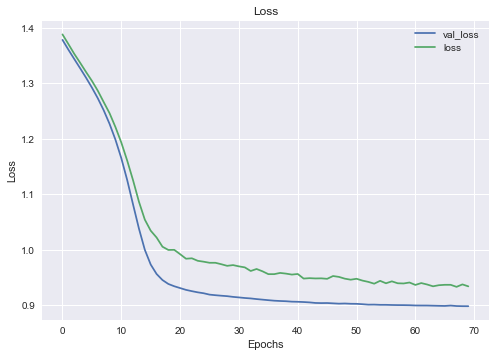

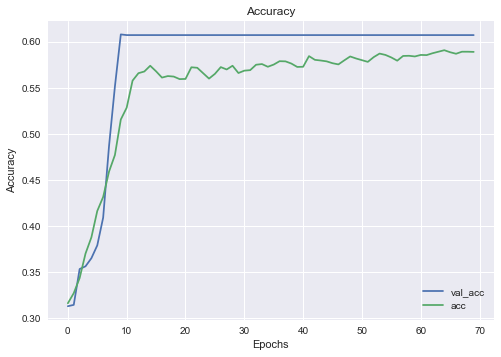

In [611]:
visualize_training_results(history)

### LSTM Model 3

In [512]:
# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model_3.h5', monitor='val_loss', save_best_only=True)]

In [520]:
model_lstm_3 = models.Sequential()


model_lstm_3.add(Dropout(0.5))
model_lstm_3.add(LSTM(50))
model_lstm_3.add(Dropout(0.5))
model_lstm_3.add(Dense(25, activation = 'relu'))
model_lstm_3.add(Dropout(0.5))

model_lstm_3.add(Dense(4, activation = 'softmax'))

model_lstm_3.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [521]:
history_3 = model_lstm_3.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    callbacks=early_stopping,
    epochs = 32,
    batch_size = 500
)

Train on 5455 samples, validate on 1364 samples
Epoch 1/32
5455/5455 [==============================] - 12s 2ms/step - loss: 1.3582 - acc: 0.5072 - val_loss: 1.3105 - val_acc: 0.6070
Epoch 2/32
5455/5455 [==============================] - 10s 2ms/step - loss: 1.2383 - acc: 0.5575 - val_loss: 1.0081 - val_acc: 0.6070
Epoch 3/32
5455/5455 [==============================] - 9s 2ms/step - loss: 1.0631 - acc: 0.5531 - val_loss: 0.9841 - val_acc: 0.6070
Epoch 4/32
5455/5455 [==============================] - 9s 2ms/step - loss: 1.0392 - acc: 0.5364 - val_loss: 0.9150 - val_acc: 0.6070
Epoch 5/32
5455/5455 [==============================] - 9s 2ms/step - loss: 1.0148 - acc: 0.5446 - val_loss: 0.9244 - val_acc: 0.6070
Epoch 6/32
5455/5455 [==============================] - 8s 2ms/step - loss: 1.0002 - acc: 0.5553 - val_loss: 0.9129 - val_acc: 0.6070
Epoch 7/32
5455/5455 [==============================] - 10s 2ms/step - loss: 0.9905 - acc: 0.5615 - val_loss: 0.9131 - val_acc: 0.6070
Epoch 8/32


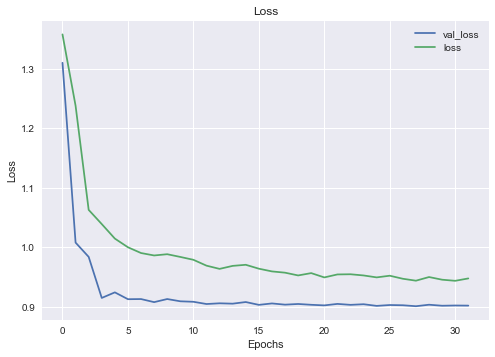

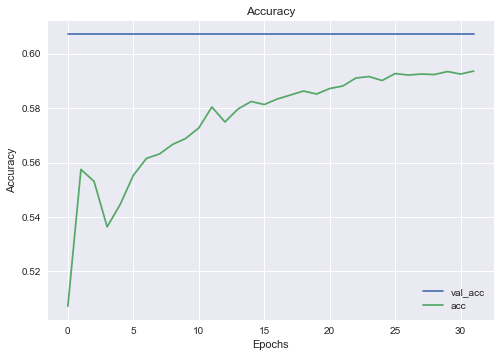

In [522]:
visualize_training_results(history_3)

In [450]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(w2v_dict)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(w2v_dict)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(w2v_dict)),
              ('Logistic Regression', LogisticRegression())])

In [456]:
data_processed['tweet_text']

0       [wesley83, 3g, iphone, 3, hrs, tweeting, rise_...
1       [jessedee, know, fludapp, awesome, ipad/iphone...
2           [swonderlin, wait, ipad, 2, also, sale, sxsw]
3       [sxsw, hope, year, 's, festival, n't, crashy, ...
4       [sxtxstate, great, stuff, fri, sxsw, marissa, ...
                              ...                        
9088                       [ipad, everywhere, sxsw, link]
9089    [wave, buzz, rt, mention, interrupt, regularly...
9090    [google, 's, zeiger, physician, never, reporte...
9091    [verizon, iphone, customers, complained, time,...
9092    [ï¡ïàü_êîò£áââ_£â_ûârt,...
Name: tweet_text, Length: 9092, dtype: object

In [455]:
target

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [457]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr)]

In [458]:
# ⏰ This cell may take several minutes to run
scores = [(name, cross_val_score(model, data_processed['tweet_text'], target, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [459]:
scores

[('Random Forest', 0.5073691157061153),
 ('Support Vector Machine', nan),
 ('Logistic Regression', nan)]